In [4]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
from utils import *
import pickle
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [6]:

compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


gbtree was choosen over dart because is faster and over the linear one because the linear one poorly perform

In [7]:
params = {
    "n_estimators": 6,
    "max_depth": 8,
    "learning_rate": 1, 
    "booster": 'gbtree', 
    "objective": 'multi:softprob',
    "n_jobs": -1,
    "random_state": 12
}

bst = XGBClassifier(**params)

le = LabelEncoder()
le.fit(ds['traffic_category'])

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], le.transform(ds['traffic_category']))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12,  stratify=y_res)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

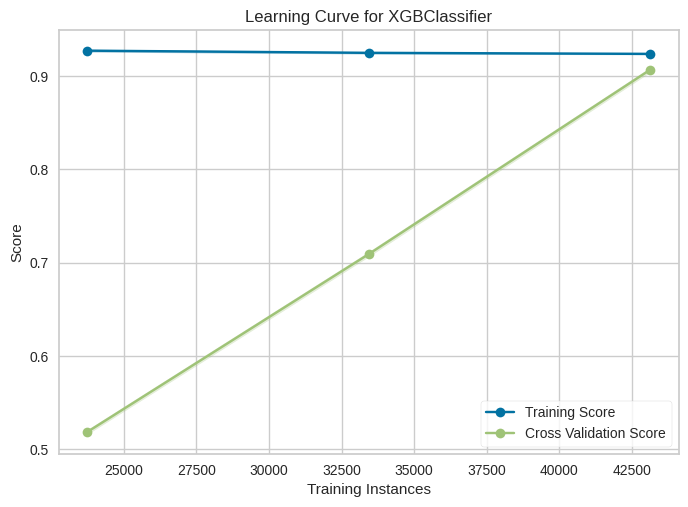

In [9]:
if True:
    cv = 10
    visualizer = LearningCurve(estimator=bst, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_res, y_res)
    visualizer.show(outpath="bst_data/learning_curve.png")

![Alt text](bst_data/learning_curve.png)

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [11]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    bst.fit(X_res.iloc[train_index], y_res[train_index])
    y_predicted_train = bst.predict(X_res.iloc[train_index])
    y_predicted_test = bst.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
Train F1: 0.9233
Test F1: 0.9078
Fold 1:
Train F1: 0.9242
Test F1: 0.9049
Fold 2:
Train F1: 0.9249
Test F1: 0.9051
Fold 3:
Train F1: 0.9246
Test F1: 0.9028
Fold 4:
Train F1: 0.9239
Test F1: 0.9076
Average Train F1: 0.9242
Average Test F1: 0.9056


In [12]:
%time bst.fit(X_train, y_train)

CPU times: user 7.13 s, sys: 7.95 ms, total: 7.14 s
Wall time: 672 ms


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=6, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
%time y_predicted_train = bst.predict(X_train)
%time y_predicted_test = bst.predict(X_test)

CPU times: user 239 ms, sys: 6.42 ms, total: 246 ms
Wall time: 50 ms
CPU times: user 341 ms, sys: 1.04 ms, total: 342 ms
Wall time: 36.9 ms


In [14]:
# Function to create dataframe with metrics
def performanceMetricsDF(
    metricsObj, yTrain, yPredTrain, yTest, yPredTest, average="binary"
):
    measures_list = ["ACCURACY", "PRECISION", "RECALL", "F1 SCORE"]
    train_results = [
        metricsObj.accuracy_score(yTrain, yPredTrain),
        metricsObj.precision_score(yTrain, yPredTrain, average=average),
        metricsObj.recall_score(yTrain, yPredTrain, average=average),
        metricsObj.f1_score(yTrain, yPredTrain, average=average),
    ]
    test_results = [
        metricsObj.accuracy_score(yTest, yPredTest),
        metricsObj.precision_score(yTest, yPredTest, average=average),
        metricsObj.recall_score(yTest, yPredTest, average=average),
        metricsObj.f1_score(yTest, yPredTest, average=average),

    ]
    resultsDF = pd.DataFrame(
        {"Measure": measures_list, "Train": train_results, "Test": test_results}
    )
    return resultsDF

In [15]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

,Measure,Train,Test
0,ACCURACY,0.926712,0.911433
1,PRECISION,0.927669,0.909529
2,RECALL,0.926712,0.911433
3,F1 SCORE,0.923941,0.907859


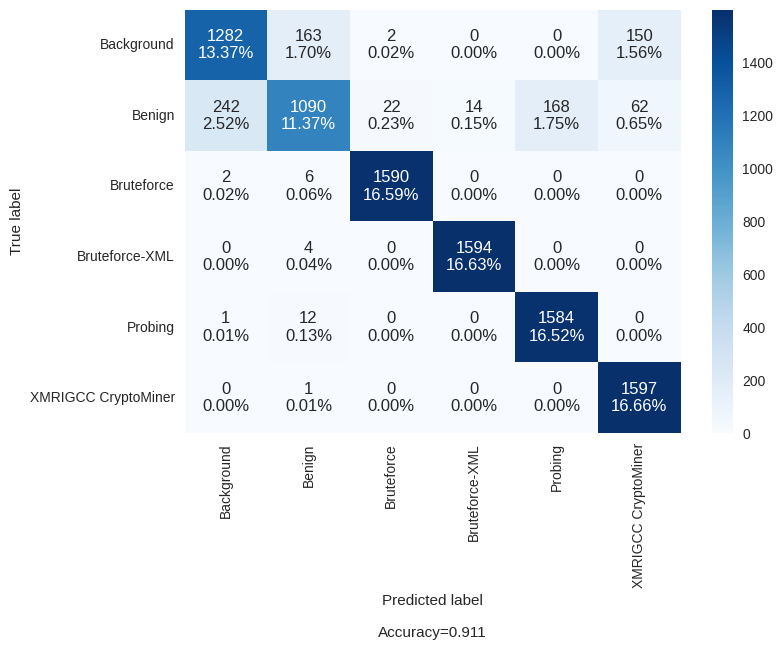

In [16]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(le.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [17]:
import xgboost as xgb

for tree_num in range(0,6):
    tree_viz = xgb.to_graphviz(bst, num_trees=0, rankdir='LR')
    tree_viz.render(f"bst_data/tree_{tree_num}")

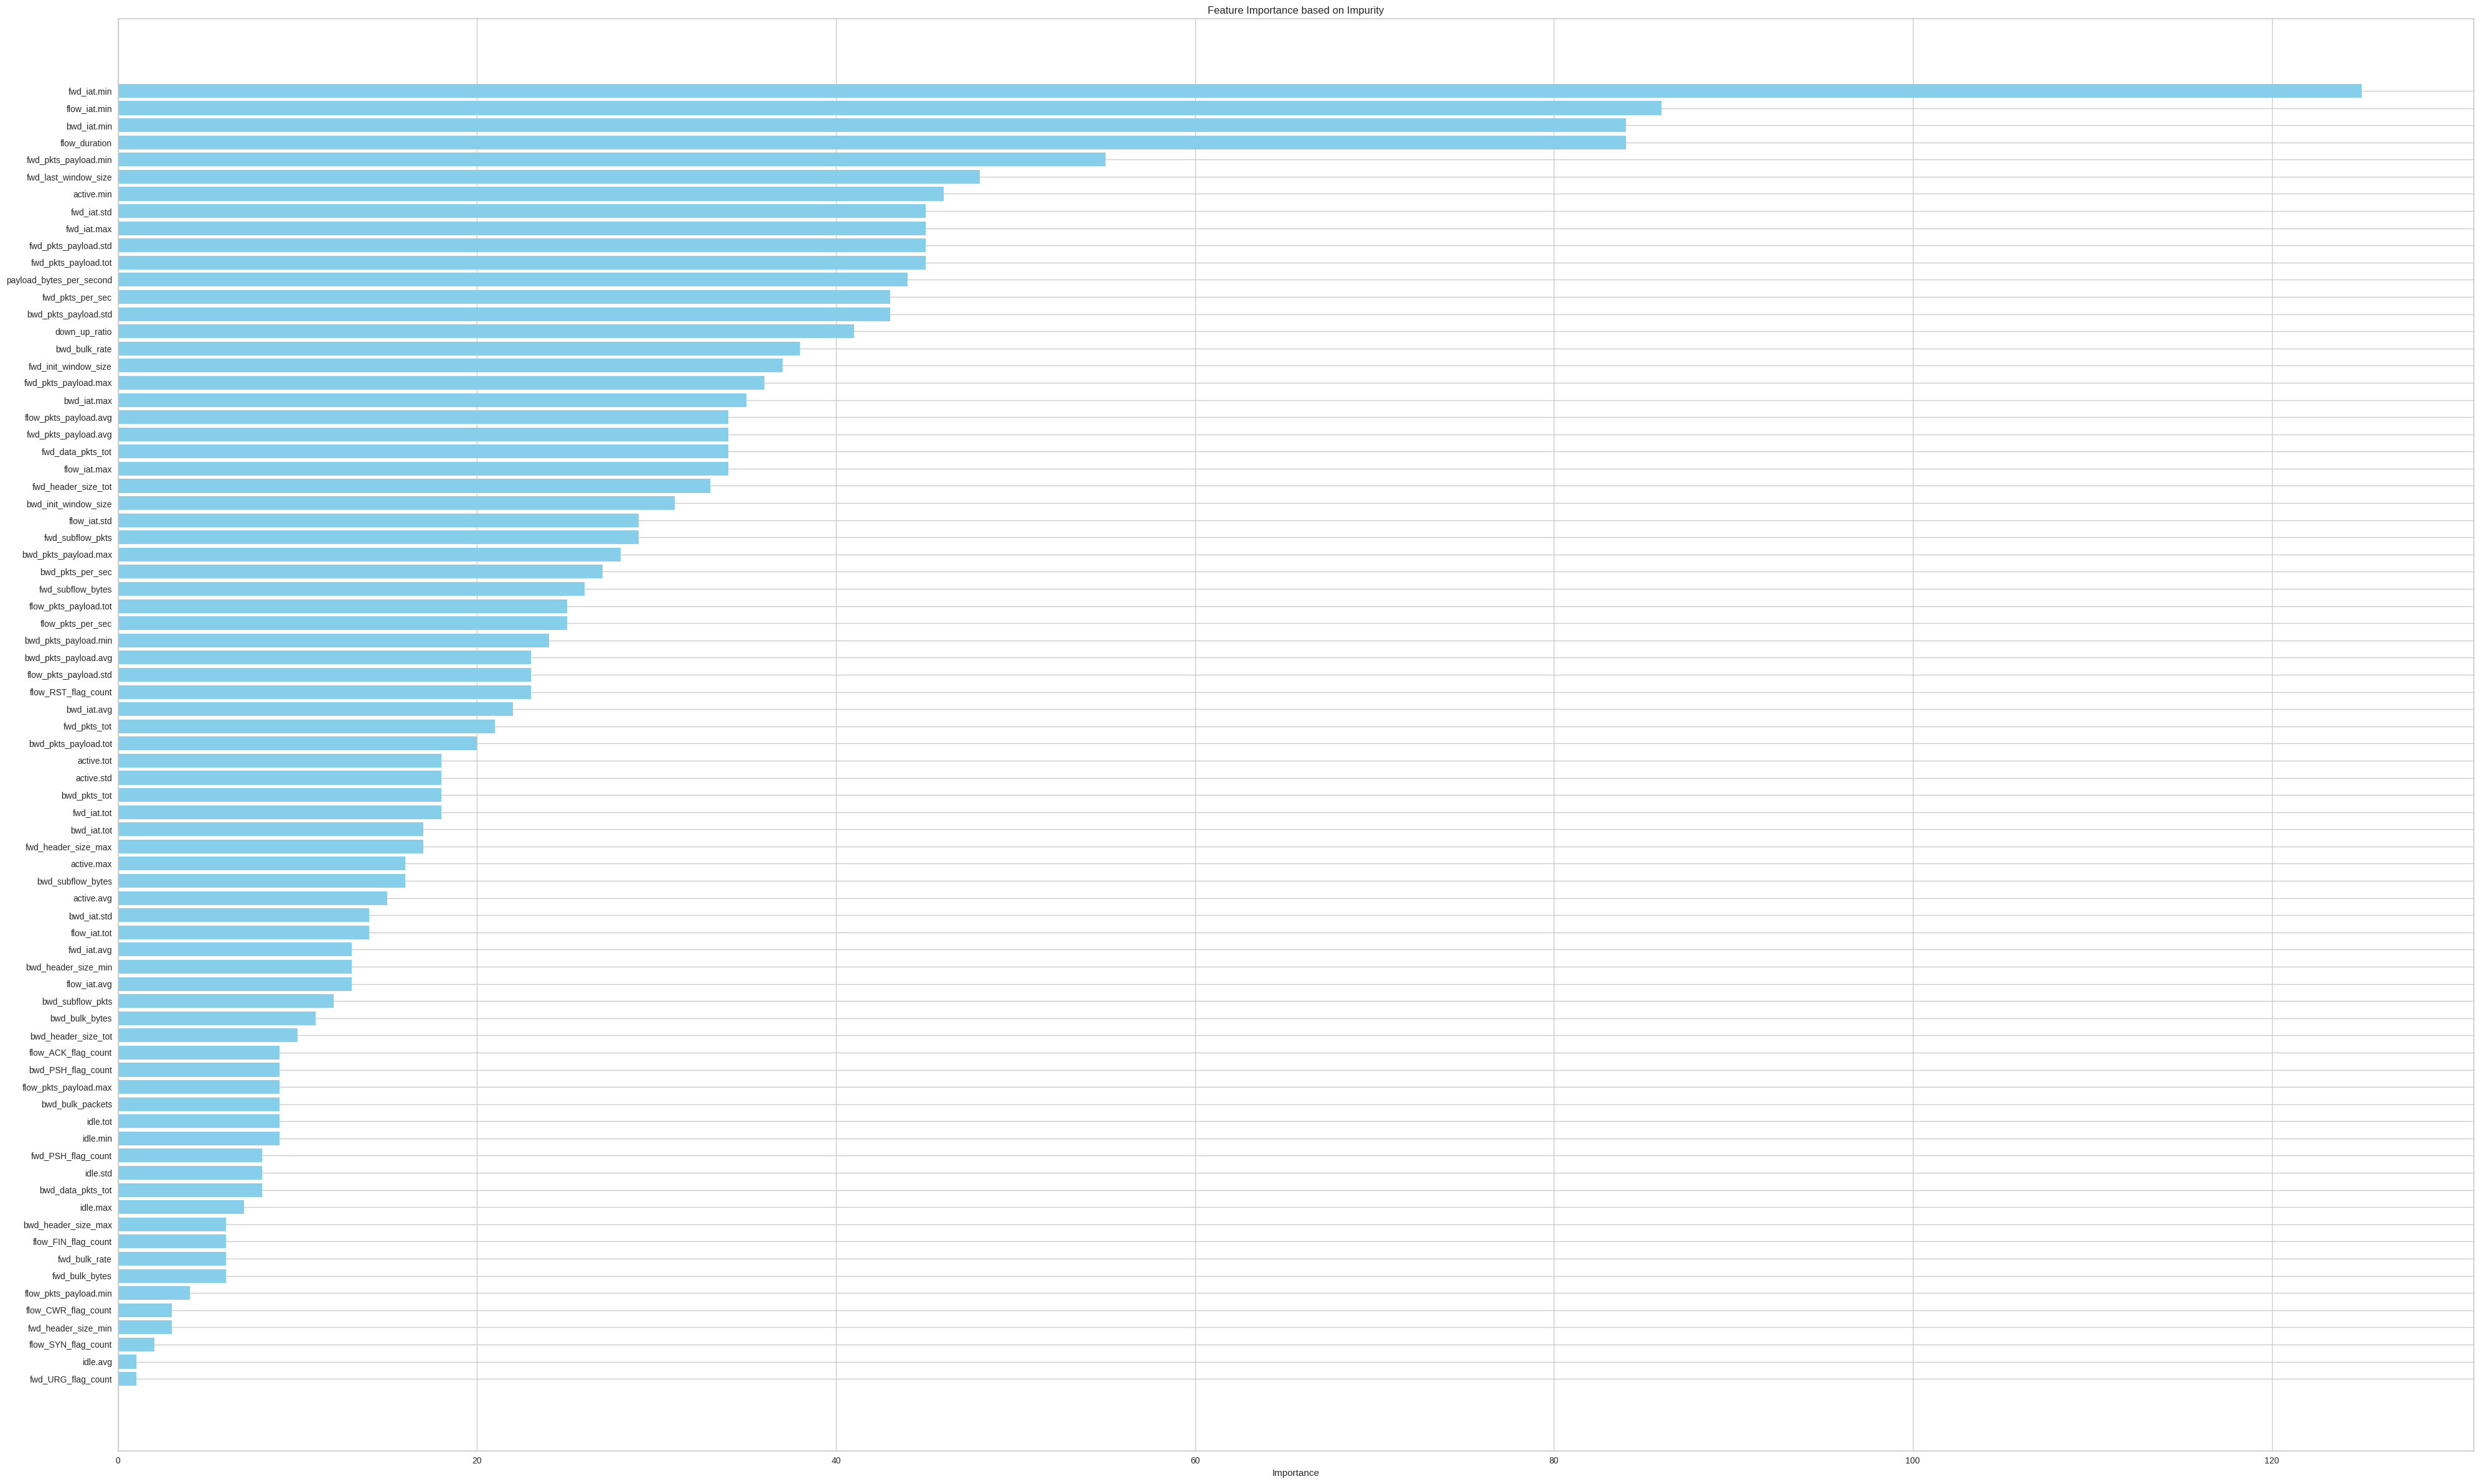

In [18]:
# Get feature importance based on impurity
impurity_importance = bst.get_booster().get_score(importance_type='weight')

# Convert the dictionary to a DataFrame
feature_importance_df = pd.DataFrame(list(impurity_importance.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Reset index
feature_importance_df.reset_index(drop=True, inplace=True)

# Plotting feature importance
plt.figure(figsize=(40, 24))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance based on Impurity')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

In [19]:
%%time

explainer = fasttreeshap.TreeExplainer(bst, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional")
sv = explainer(X_train)

[20:30:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 229650/230052 [05:01<00:00]        

CPU times: user 4min 58s, sys: 807 ms, total: 4min 59s
Wall time: 5min 1s


## Background shap

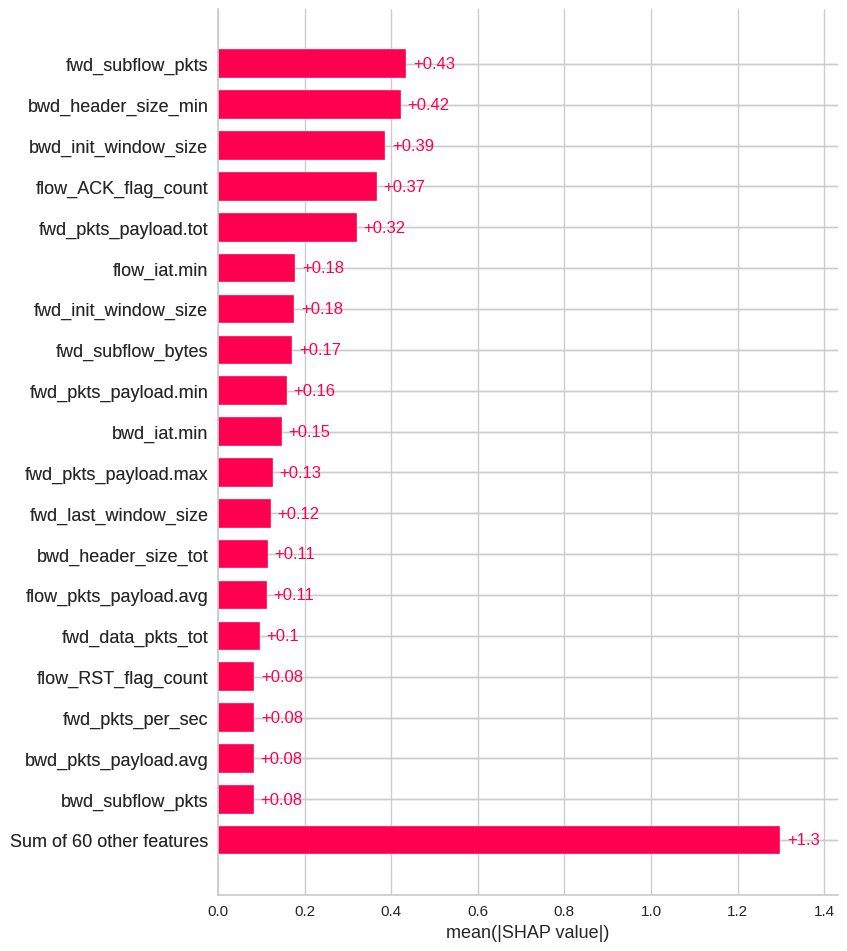

In [21]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

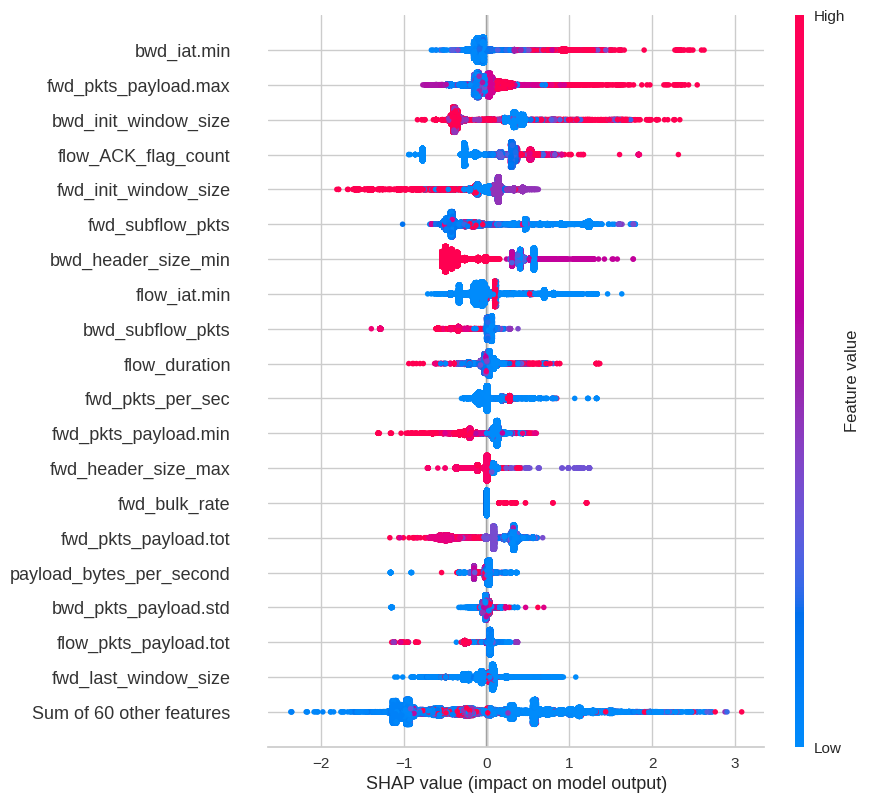

In [22]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

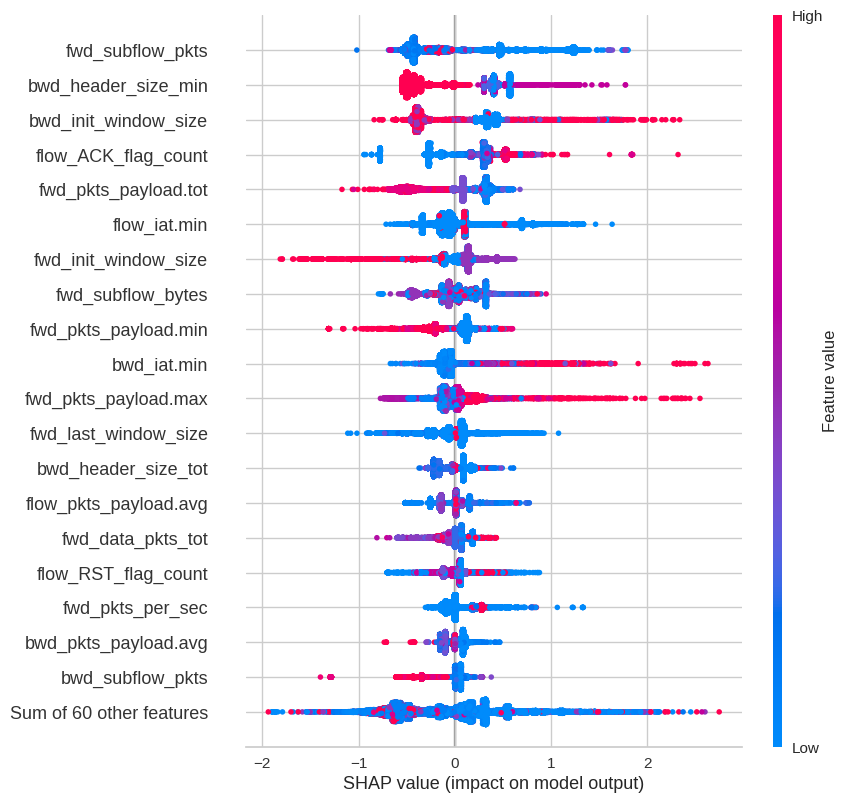

In [23]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bening shap

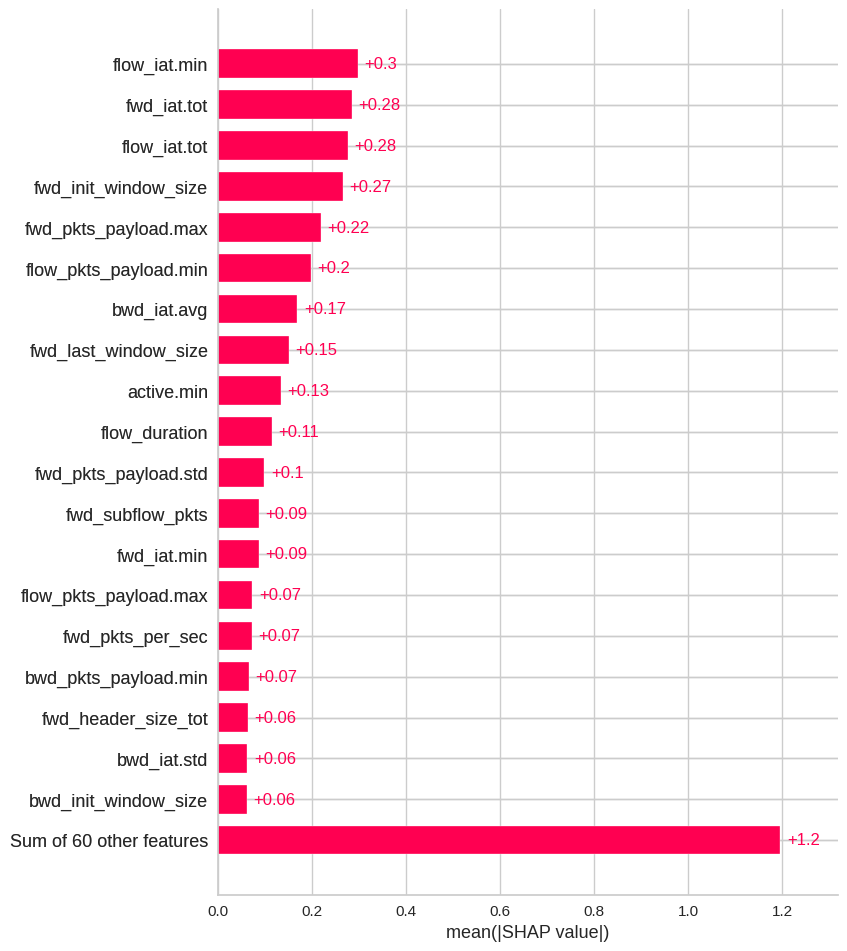

In [24]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

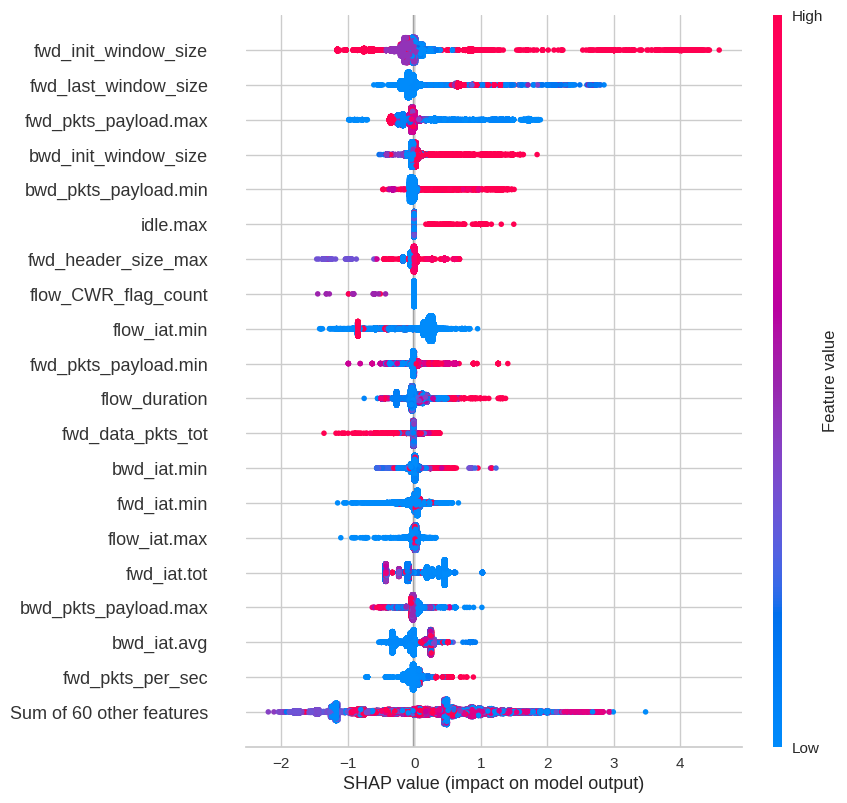

In [25]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

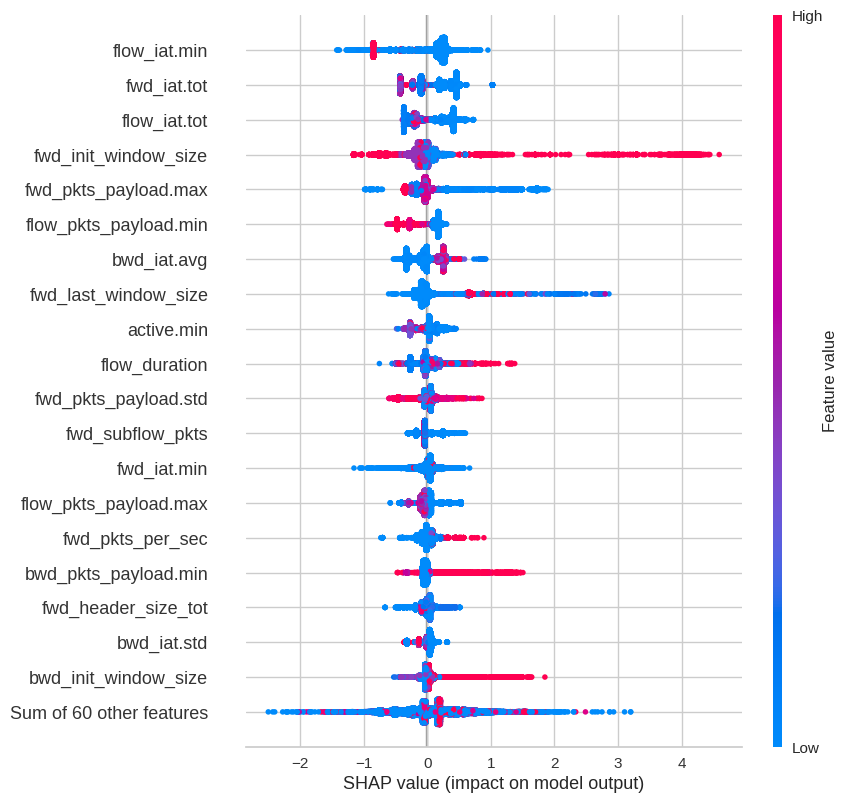

In [26]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce shap

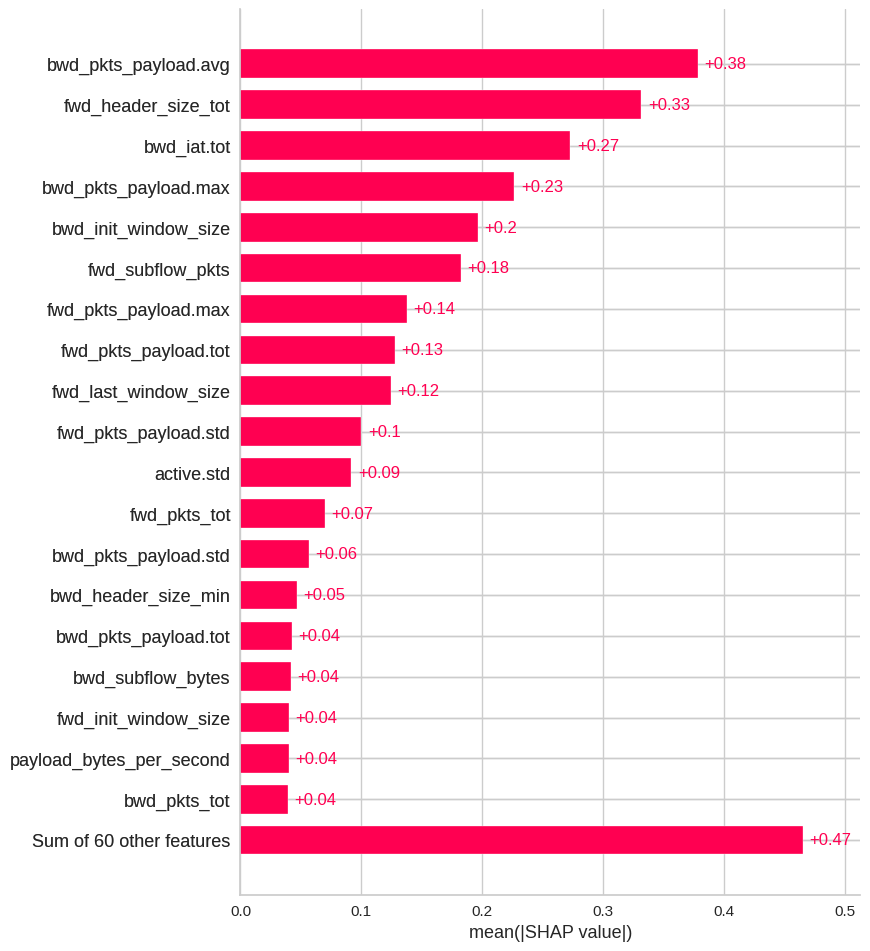

In [28]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

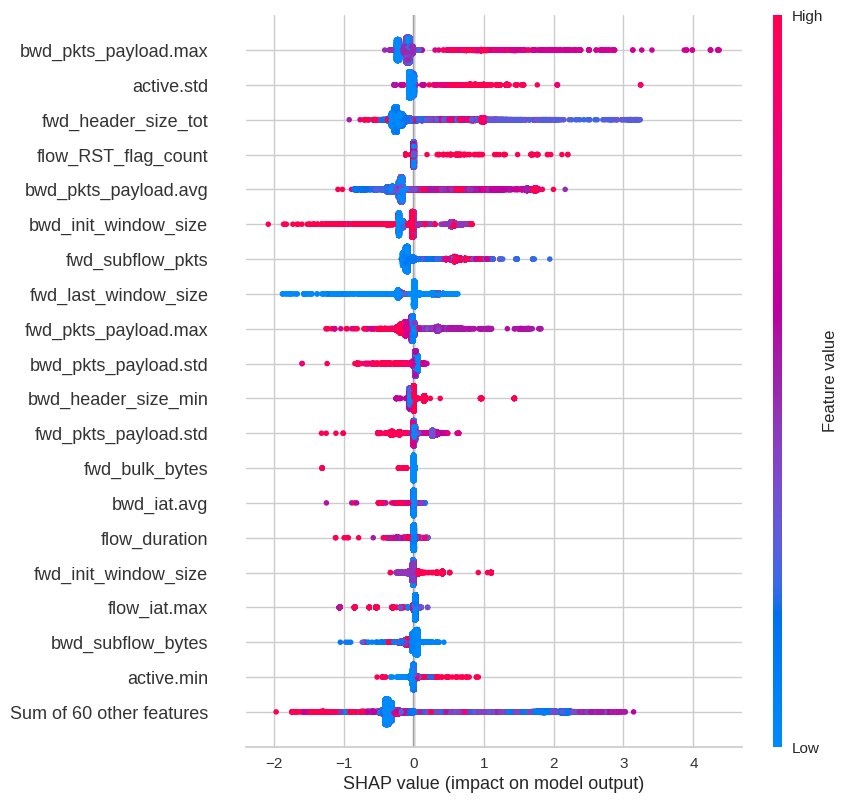

In [29]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

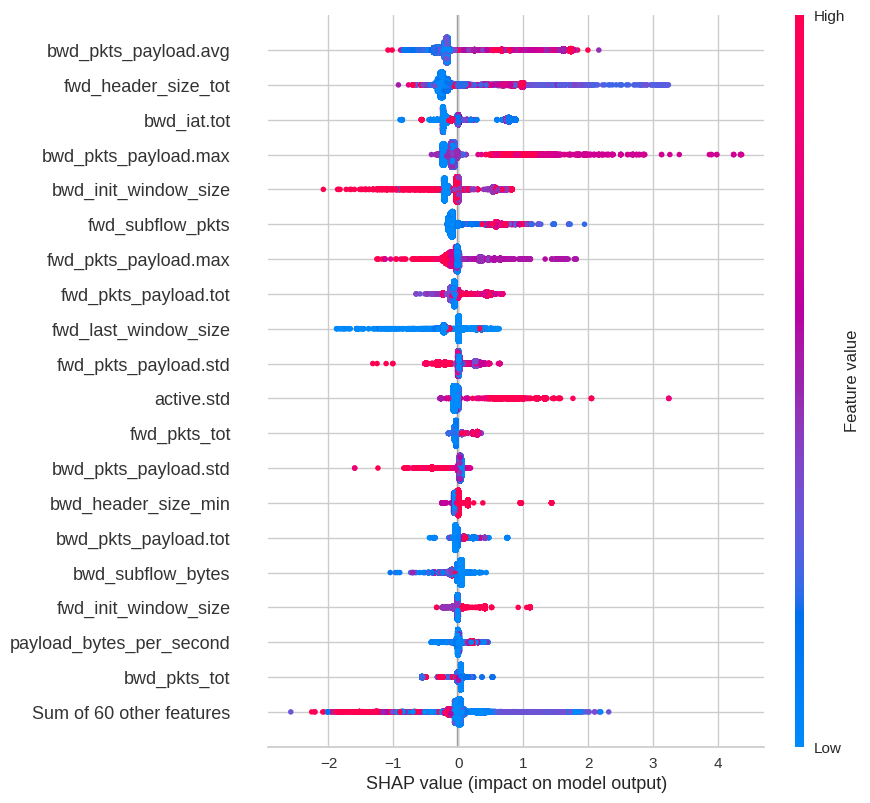

In [30]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce XML shap

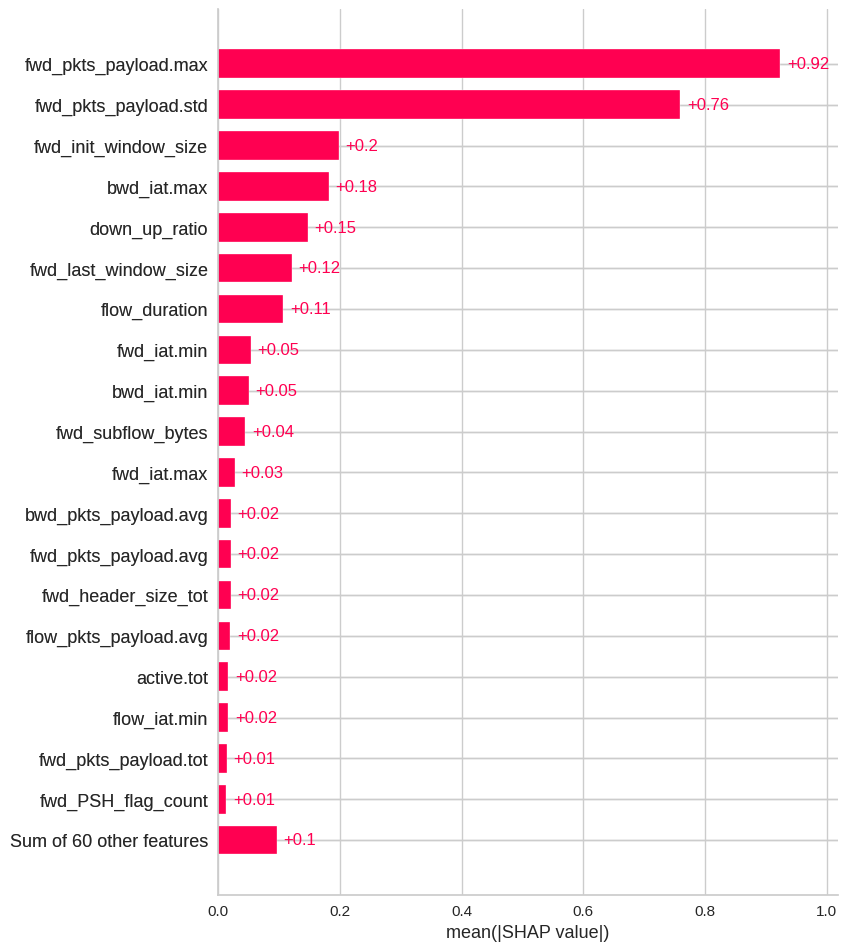

In [31]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

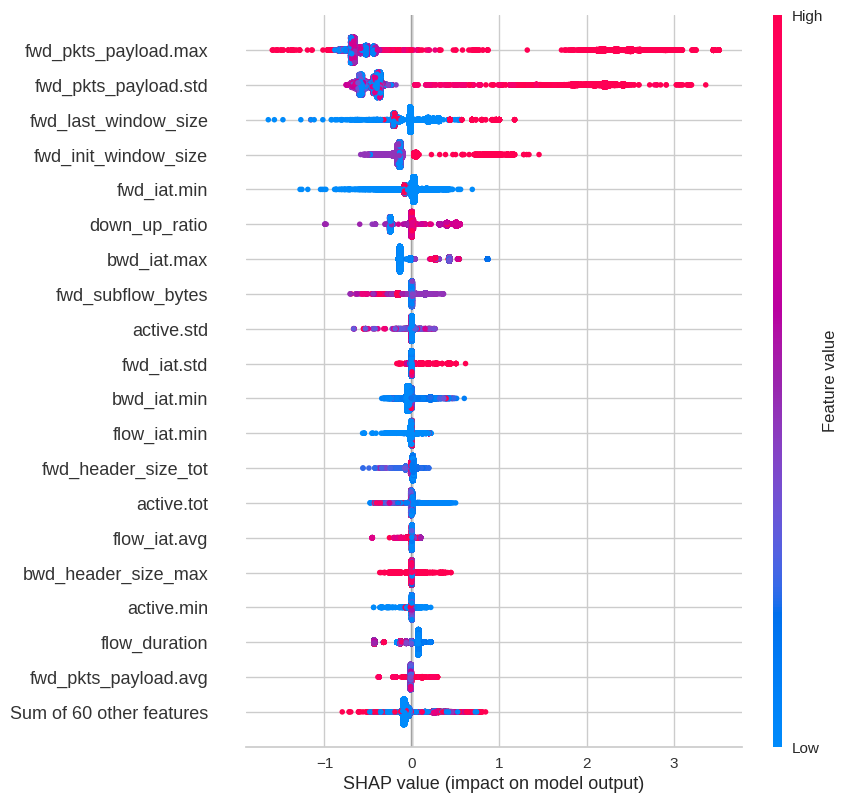

In [32]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

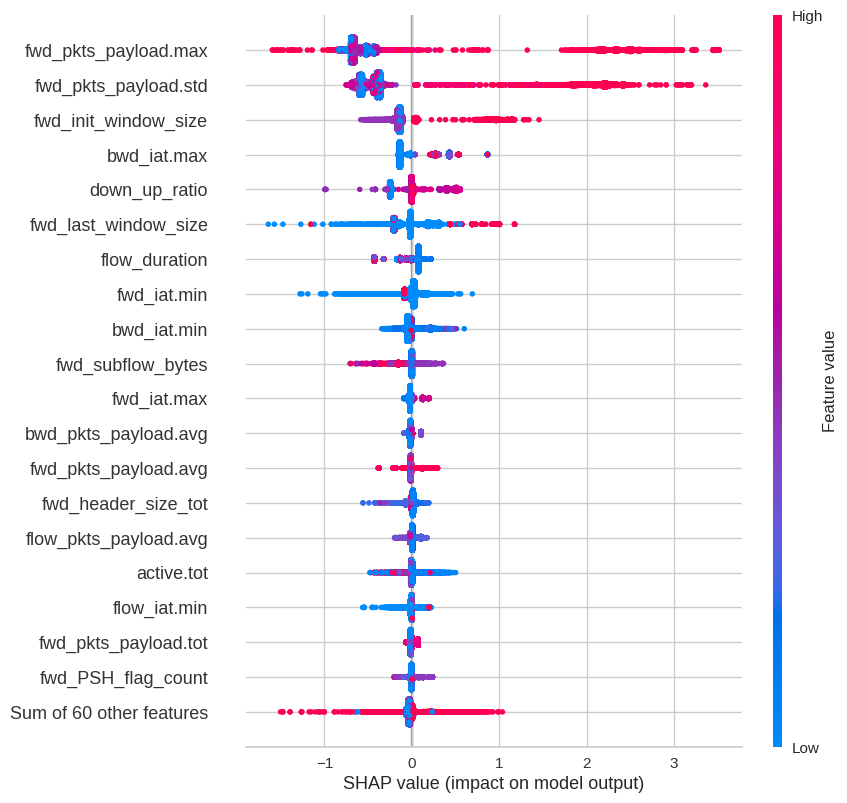

In [33]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Probing shap

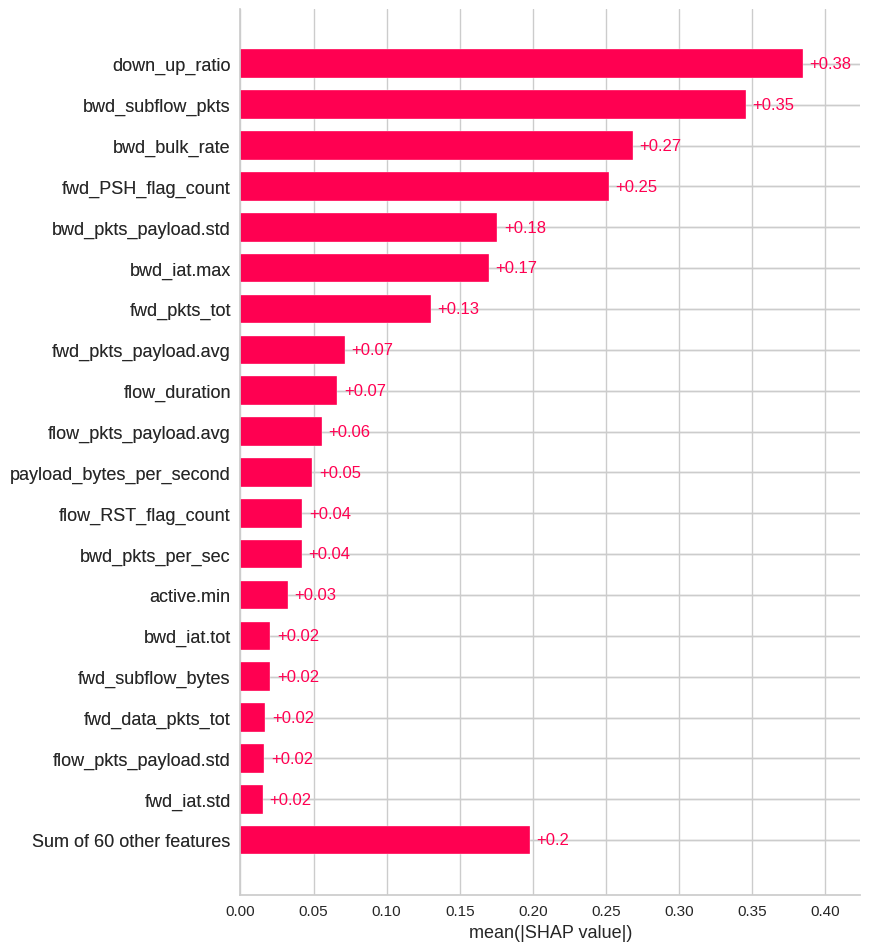

In [34]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

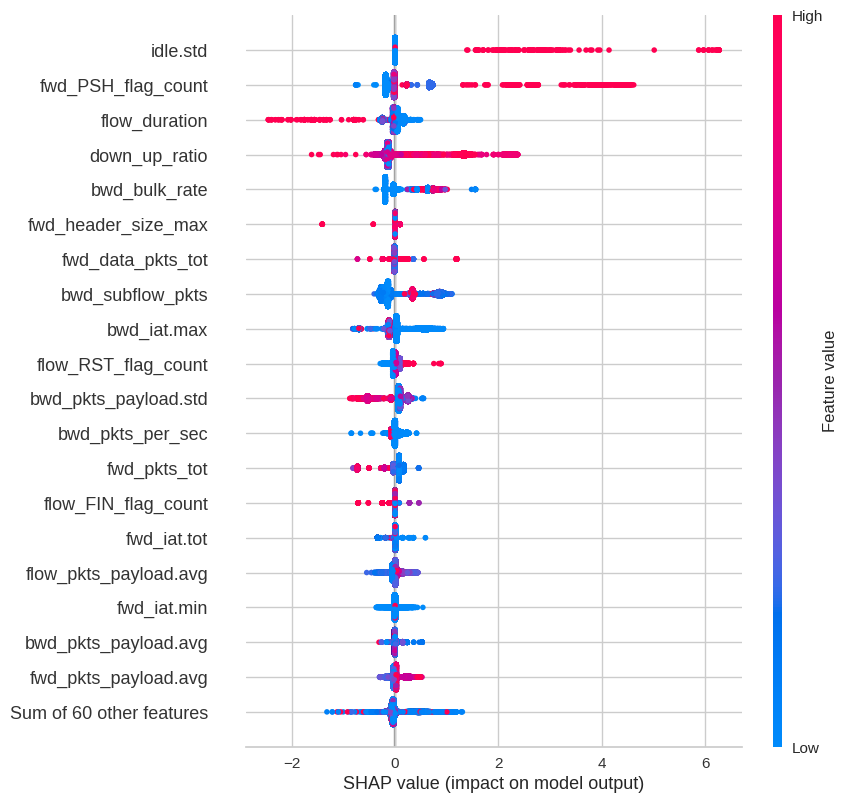

In [35]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

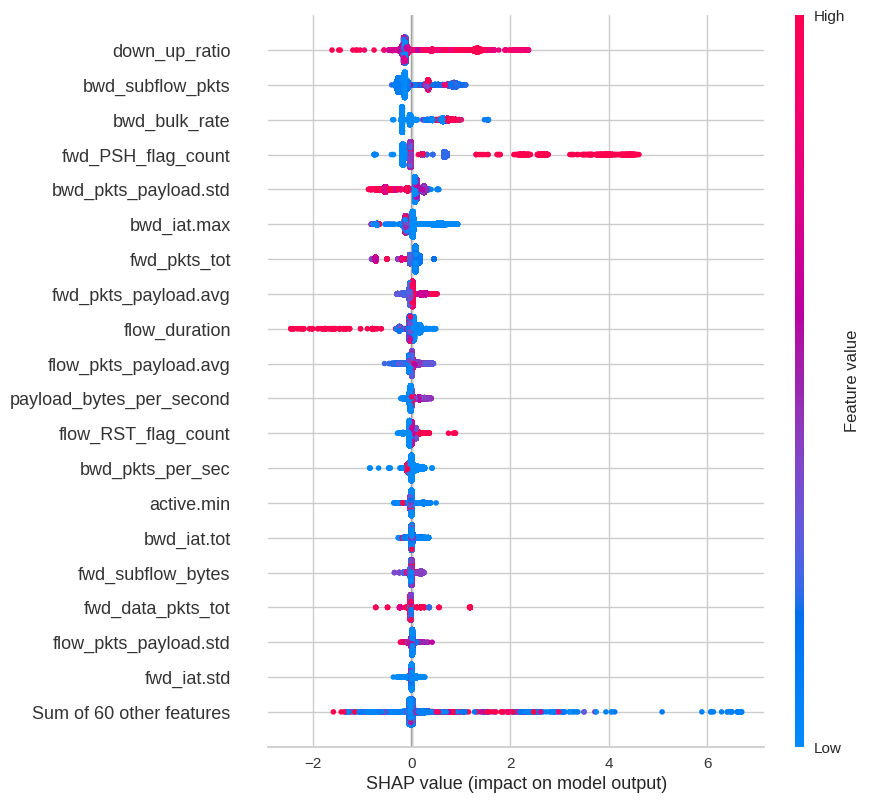

In [36]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Miner shap

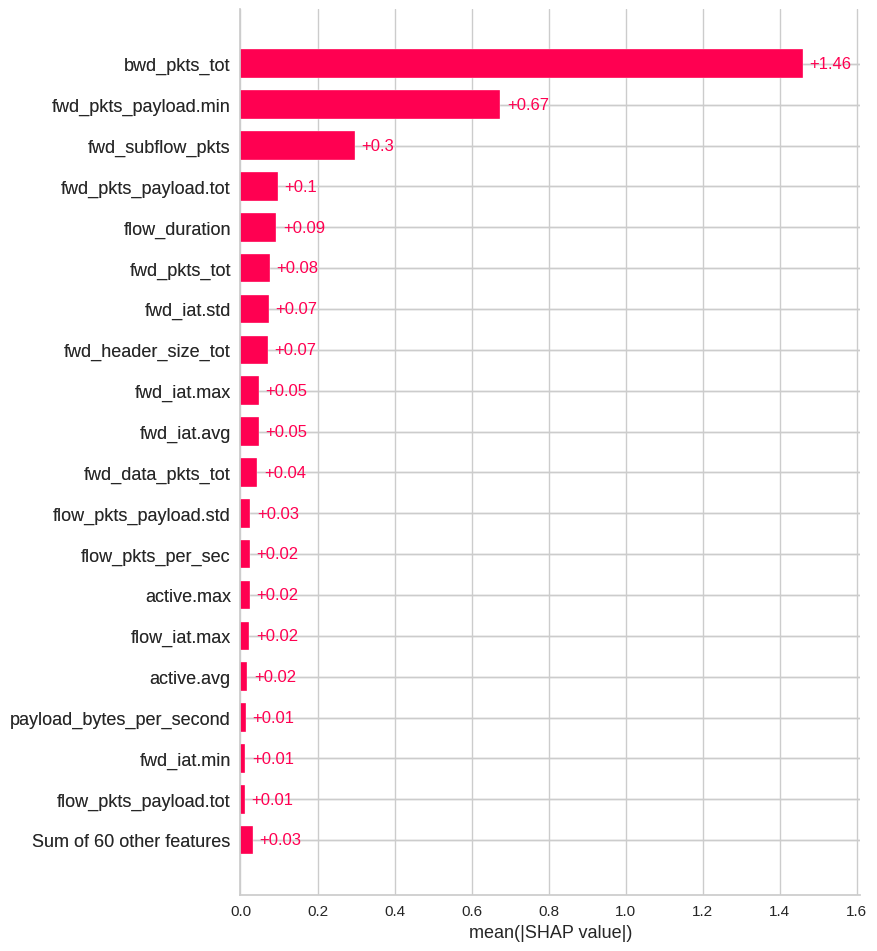

In [37]:
exp = Explanation(sv.values[:,:,5], 
                  sv.base_values[:,5], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

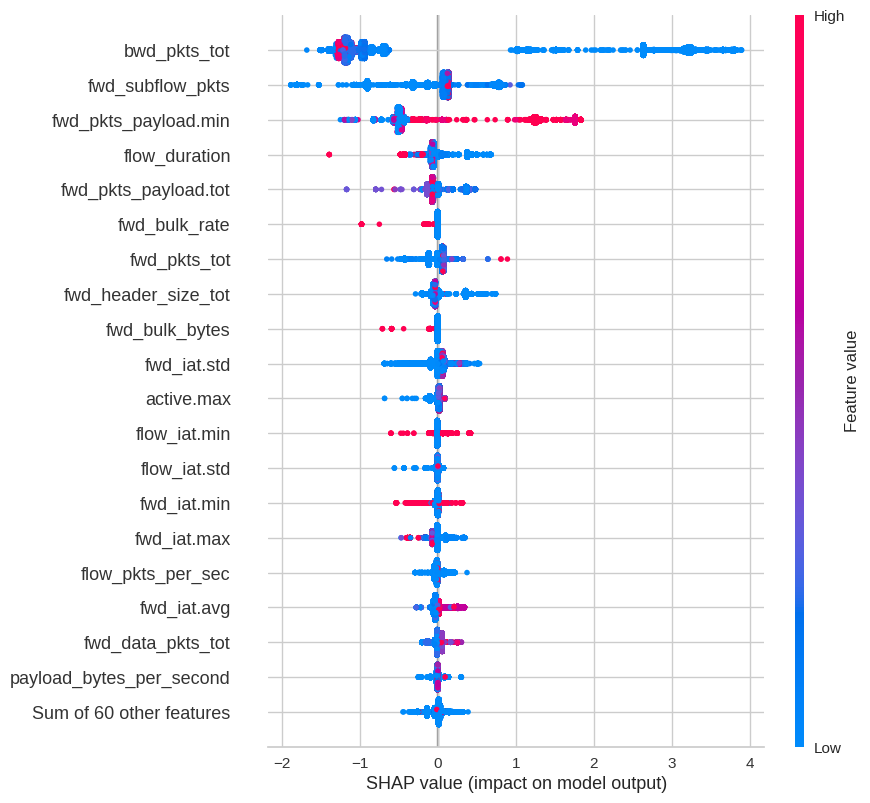

In [38]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

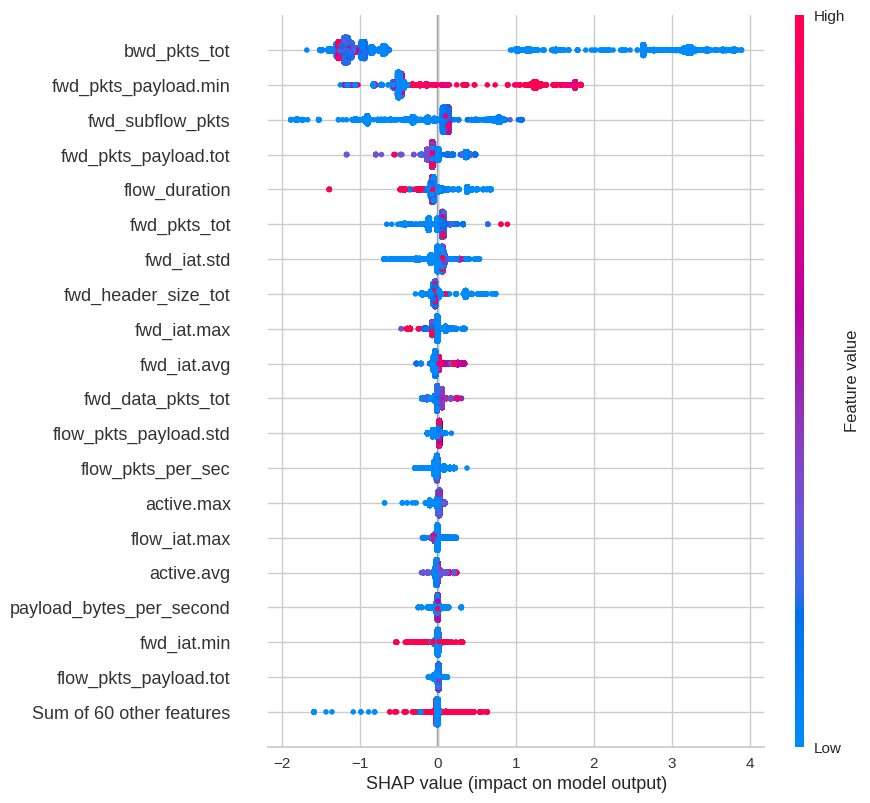

In [39]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

In [61]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
58,1.230295,fwd_subflow_bytes
26,1.020725,fwd_pkts_payload.max
3,0.455185,fwd_data_pkts_tot
78,0.442686,fwd_last_window_size
27,0.272001,fwd_pkts_payload.tot
76,0.268602,fwd_init_window_size
0,0.261091,flow_duration
30,0.243537,bwd_pkts_payload.min
38,0.240074,flow_pkts_payload.avg
45,0.232504,bwd_iat.min


In [62]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [63]:
%%time

if False:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('abc_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('abc_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

Running the cross validation
testing with 59 features
Running the cross validation
testing with 58 features
Running the cross validation
testing with 57 features
Running the cross validation
testing with 56 features
Running the cross validation
testing with 55 features
Running the cross validation
testing with 54 features
Running the cross validation
testing with 53 features
Running the cross validation
testing with 52 features
Running the cross validation
testing with 51 features
Running the cross validation
testing with 50 features
Running the cross validation
testing with 49 features
Running the cross validation
testing with 48 features
Running the cross validation
testing with 47 features
Running the cross validation
testing with 46 features
Running the cross validation
testing with 45 features
Running the cross validation
testing with 44 features
Running the cross validation
testing with 43 features
Running the cross validation
testing with 42 features
Running the cross validation

<Axes: xlabel='n_features', ylabel='cv_time'>

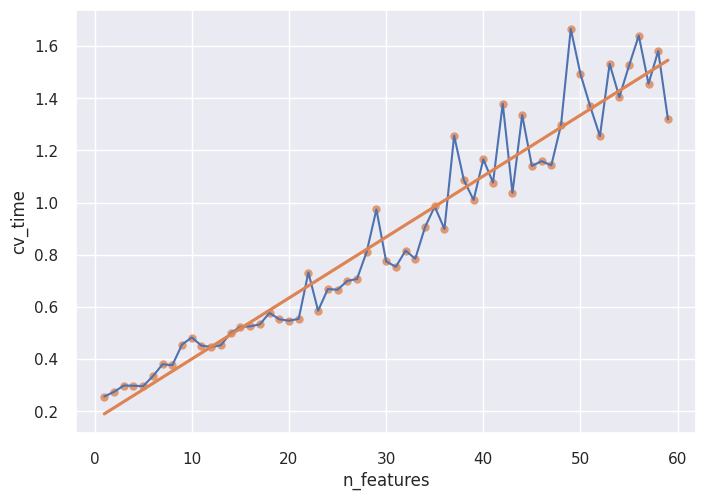

In [64]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

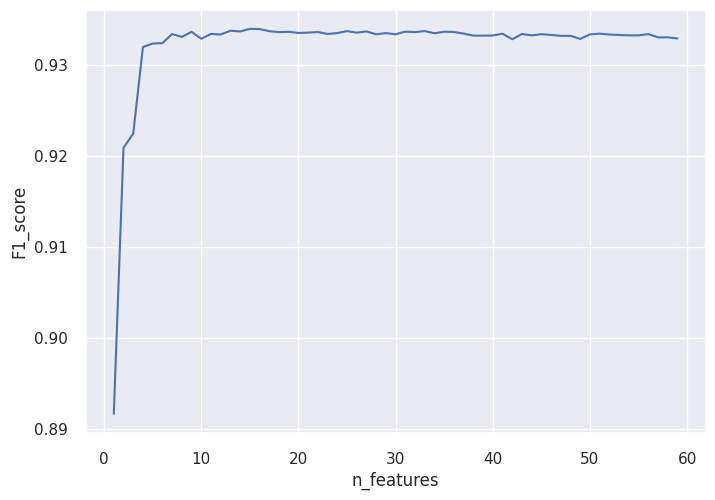

In [65]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

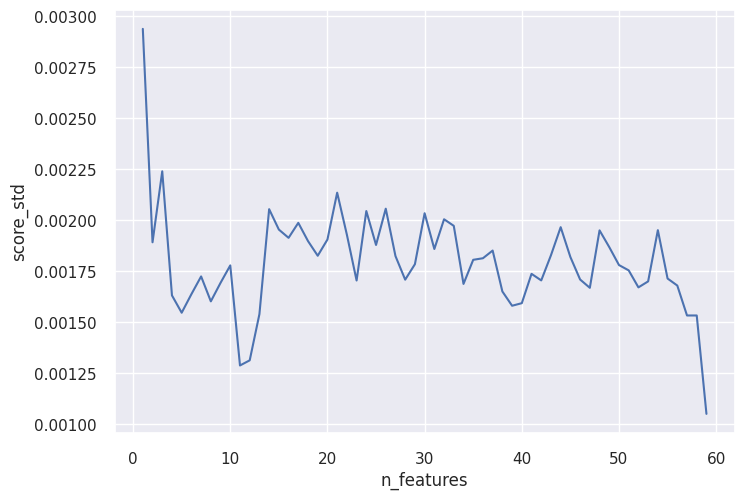

In [66]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [67]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
44,0.933954,0.001955,15,0.523517
43,0.933930,0.001914,16,0.525513
46,0.933751,0.001540,13,0.453145
26,0.933709,0.001973,33,0.784604
34,0.933706,0.001879,25,0.665862
42,0.933704,0.001988,17,0.532903
32,0.933673,0.001825,27,0.707150
45,0.933670,0.002055,14,0.499854
28,0.933649,0.001859,31,0.753650
24,0.933642,0.001806,35,0.984857


In [68]:
%%time

if False:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('abc_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('abc_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 59 features
Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
training with 58 features
Running the cross validation
training with 57 features
Running the cross validation
training with 56 features
Running the cross validation
training with 55 features
Running the cross validation
training with 54 features
Running the cross validation
training with 53 features
Running the cross validation
training with 52 features
Running the cross validation
training with 51 features
Running the cross validation
training with 50 features
Running the cross validation
training with 49 features
Running the cross validation
training with 48 features
Running the cross validation
training with 47 features
Running the cross validation
training with 46 features
Running the cross validation
training with 45 features
Running the cross validation
training with 44 features
Running the cross validation
training with 43 features
Ru

Here we can have zero on the results of f1 and recall that means that the model has failed to detect the attack, while the cross validation result is usefull only to see how well the model is scoring with all the data except the one regarding the attack

In [69]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [70]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
161,0.384746,0.269029,0.675149,0.937003,0.003970,16,Bruteforce,0.064991,0.004762,1
142,0.377820,0.263145,0.669640,0.937084,0.003999,35,Bruteforce,0.133551,0.007548,1
164,0.377990,0.263145,0.670708,0.937304,0.004435,13,Bruteforce,0.076422,0.006269,1
162,0.375259,0.260891,0.668163,0.937296,0.003882,15,Bruteforce,0.086757,0.005955,1
144,0.372269,0.258137,0.667314,0.936599,0.004537,33,Bruteforce,0.129717,0.007703,1
...,...,...,...,...,...,...,...,...,...,...
195,0.000222,0.000125,0.000967,0.936520,0.003498,41,Bruteforce-XML,0.137488,0.009267,1
192,0.000222,0.000125,0.000967,0.936126,0.003361,44,Bruteforce-XML,0.169631,0.009338,1
191,0.000222,0.000125,0.000972,0.935939,0.003250,45,Bruteforce-XML,0.146401,0.052774,1
131,0.000222,0.000125,0.000970,0.936062,0.004938,46,Bruteforce,0.135592,0.022694,1


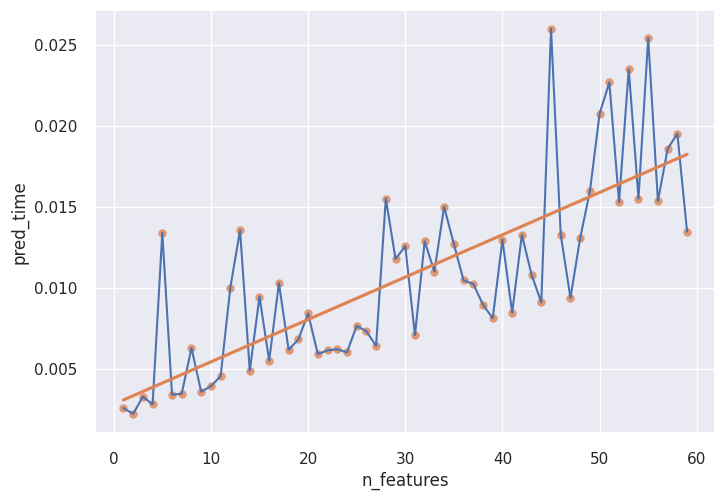

In [71]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

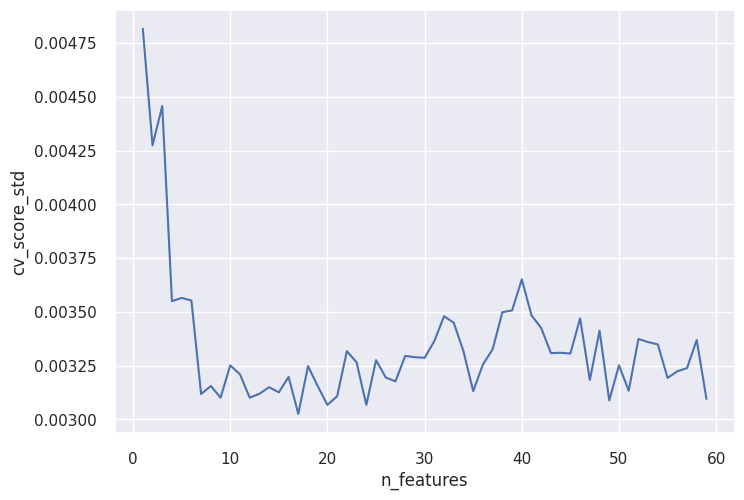

In [72]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [73]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
13,0.185444,0.128537,0.332834,0.949954,0.003119,0.061166,0.013555,0.50
1,0.129266,0.084283,0.296202,0.906671,0.004816,0.027457,0.002574,1.00
10,0.125719,0.082937,0.268520,0.949617,0.003251,0.068887,0.003928,0.50
14,0.122746,0.082280,0.256028,0.949958,0.003149,0.063382,0.004883,0.50
20,0.125701,0.081247,0.277734,0.949898,0.003067,0.076660,0.008413,0.50
21,0.115286,0.073892,0.263990,0.949736,0.003107,0.091353,0.005914,0.50
16,0.106817,0.073391,0.208592,0.949779,0.003197,0.081598,0.005497,0.50
15,0.101613,0.069698,0.197312,0.949817,0.003125,0.073938,0.009449,0.50
35,0.094455,0.065786,0.167410,0.949651,0.003131,0.139645,0.012707,0.25


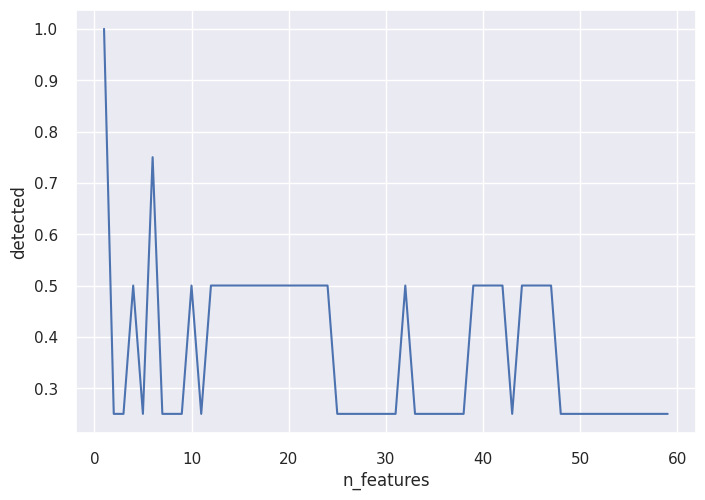

In [74]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

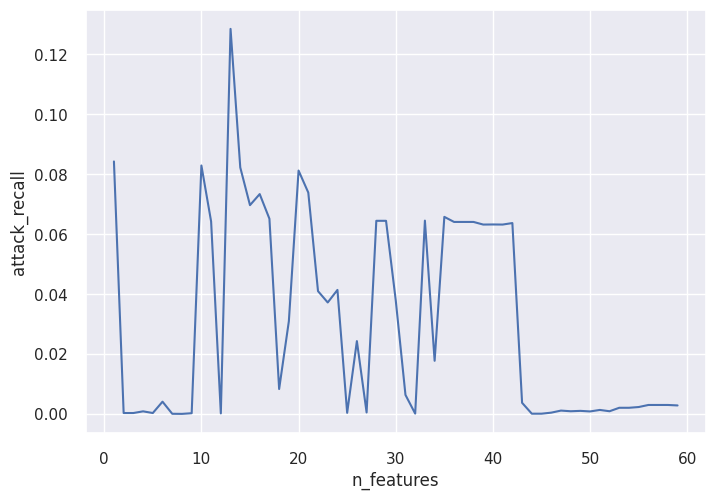

In [75]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [76]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
13,0.185444,0.128537,0.332834,0.949954,0.003119,0.061166,0.013555
1,0.129266,0.084283,0.296202,0.906671,0.004816,0.027457,0.002574
10,0.125719,0.082937,0.268520,0.949617,0.003251,0.068887,0.003928
20,0.125701,0.081247,0.277734,0.949898,0.003067,0.076660,0.008413
14,0.122746,0.082280,0.256028,0.949958,0.003149,0.063382,0.004883
21,0.115286,0.073892,0.263990,0.949736,0.003107,0.091353,0.005914
16,0.106817,0.073391,0.208592,0.949779,0.003197,0.081598,0.005497
15,0.101613,0.069698,0.197312,0.949817,0.003125,0.073938,0.009449
35,0.094455,0.065786,0.167410,0.949651,0.003131,0.139645,0.012707


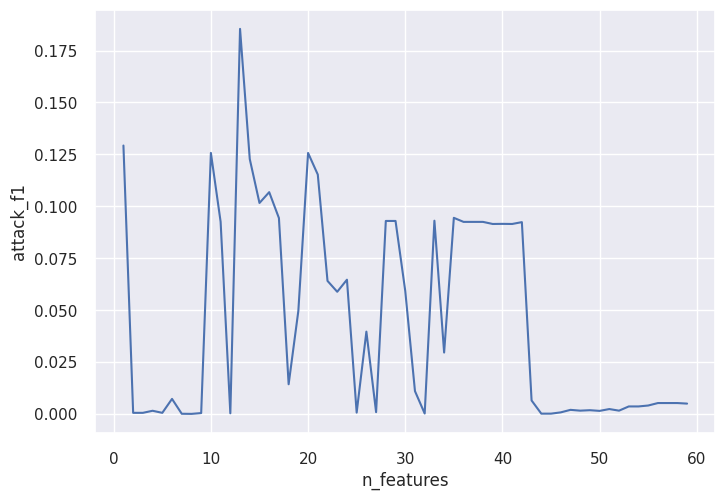

In [77]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [79]:
zero_day_feature_reduction_scores.query('n_features == 13')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
46,0.000000,0.000000,0.000000,0.968308,0.001592,13,XMRIGCC CryptoMiner,0.038944,0.030742,0
105,0.000000,0.000000,0.000000,0.958016,0.003442,13,Probing,0.075572,0.006774,0
164,0.377990,0.263145,0.670708,0.937304,0.004435,13,Bruteforce,0.076422,0.006269,1
223,0.363785,0.251002,0.660626,0.936189,0.003006,13,Bruteforce-XML,0.053726,0.010434,1
